# Constantes y Logger

In [1]:
# %cd ~/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters

In [2]:
SAVE_FIGS = True  # If you want to save the figures.

In [3]:
import torch
import bwb.plotters as plotters

In [4]:
import torch
import numpy as np
import random

SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

torch.backends.cudnn.deterministic = True

In [5]:
from bwb import _logging as logging

log = logging.get_logger(__name__)

In [6]:
from pathlib import Path

CURR_PATH = Path().absolute()
print(f"{CURR_PATH = }")
BASE_PATH = CURR_PATH.parent.parent
print(f"{BASE_PATH = }")
DATA_PATH = BASE_PATH / "data"
print(f"{DATA_PATH = }")
NETS_PATH = BASE_PATH / "wgan_gp" / "networks" 
print(f"{NETS_PATH = }")
IMGS_PATH = CURR_PATH / "imgs" / "notebook-01"
IMGS_PATH.mkdir(parents=True, exist_ok=True)
print(f"{IMGS_PATH = }")

CURR_PATH = PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/examples/02-distribution-sampler')
BASE_PATH = PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters')
DATA_PATH = PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/data')
NETS_PATH = PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/wgan_gp/networks')
IMGS_PATH = PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/examples/02-distribution-sampler/imgs/notebook-01')


# Sampleador de Distribuciones

La clase padre de todos los muestreadores de distribuciones es el `DistributionSampler`. Básicamente, este define los siguientes métodos:
* `draw(seed=None) -> Distribution`: Muestrea una distribución. Si `seed=None` no se utiliza la semilla. Es un método abstracto que se tiene que sobre-escribir.
* `rvs(size=1, seed=None) -> Sequence[Distribution]`: Muestrea una secuencia de distribuciones de tamaño `size`. Si `seed=None` no se utiliza la semilla. Es un método abstracto que se tiene que sobre-escribir.
* `save(filename)`: Método que salva el muestreador en el archivo `filename`.
* `load(filename) -> Self`: Método que carga el muestreador en el archivo `filename`.

## Distribuciones Discretas

Muestreador de Distribuciones a soporte discreto. Usualmente necesitan un conjunto de modelos.

Un ejemplo sería utilizar un dataset como conjunto de modelos.

isinstance(ds, DiscreteModelsSetP) = True


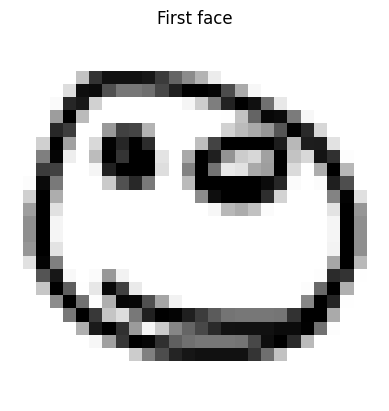

In [7]:
from quick_torch import QuickDraw
import torchvision.transforms.v2 as T
from pathlib import Path

transforms = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Lambda(lambda x: x.squeeze()),
])

ds = QuickDraw(
    DATA_PATH,
    categories="face",
    download=True,
    transform=transforms,
)

# You can use the wrapper to transform the usual DataSet into a model set
from bwb.distributions.models import DiscreteModelsSetP, ModelDataset

ds = ModelDataset(ds)

print(f"{isinstance(ds, DiscreteModelsSetP) = }")

_ = plotters.plot_draw(ds.get(0), title="First face")

In [8]:
from bwb.distributions.distribution_samplers import UniformDiscreteSampler

dist_sampler = UniformDiscreteSampler().fit(ds)
dist_sampler

UniformDiscreteSampler(n_models=161666, )

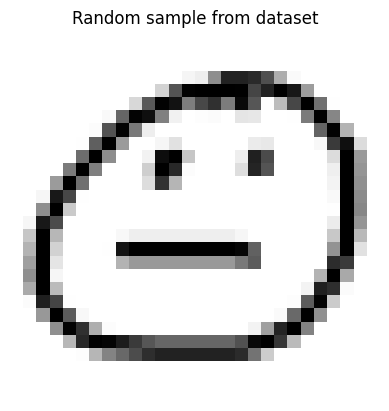

In [9]:
_ = plotters.plot_draw(dist_sampler.draw(), title="Random sample from dataset")

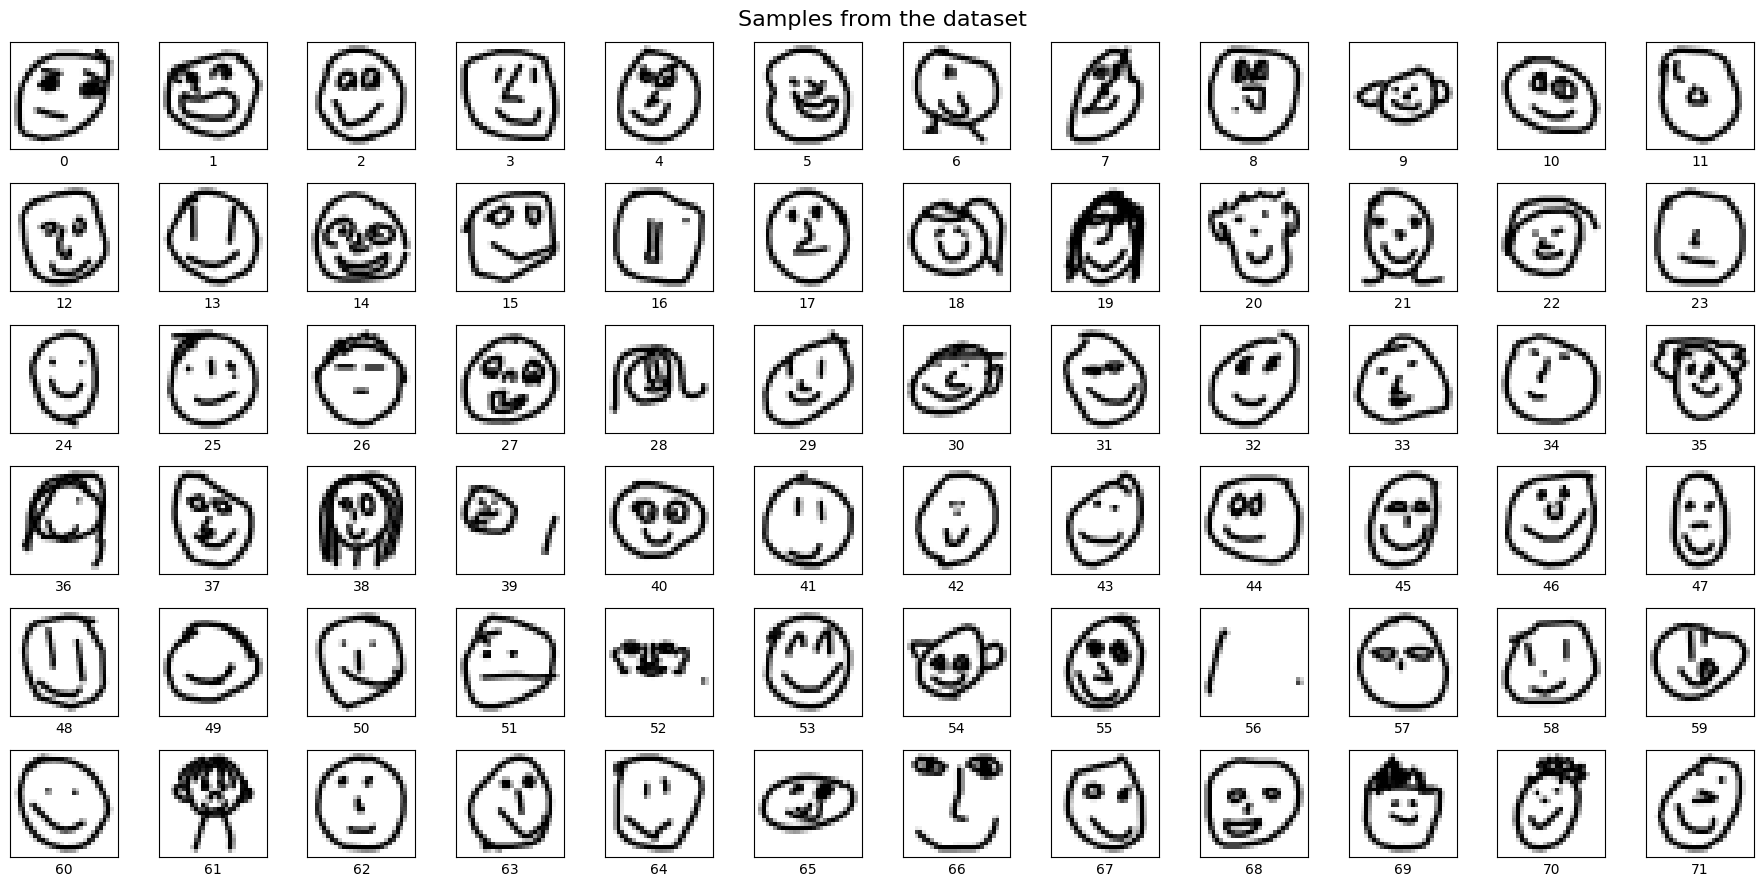

In [9]:
n_rows, n_cols = 6, 12
max_imgs = n_rows * n_cols
fig, ax = plotters.plot_list_of_draws(
    dist_sampler.rvs(max_imgs), 
    n_rows=n_rows, n_cols=n_cols,
    title=f"Samples from the dataset"
)

In [10]:
if SAVE_FIGS:
    PATH_TO_SAVE = IMGS_PATH / f"{dist_sampler.__class__.__name__}-{n_rows}x{n_cols}"
    fig.savefig(PATH_TO_SAVE.with_suffix(".pdf"))
    fig.savefig(PATH_TO_SAVE.with_suffix(".png"))

También existe la clase `bwb.distributions.posterior_samplers.ExplicitPosteriorSampler`, que es un sampler a soporte discreto.

## Distribuciones Continuas

Distribuciones que tienen un soporte continuo. En este caso, heredan de la clase `bwb.distributions.distribution_samplers.ContinuousDistribSampler`. Dentro del cuál, el más destacable es la clase abstracta `bwb.distributions.distribution_samplers.BaseGeneratorDistribSampler`.

Para utilizarlo, es necesario utilizar un generador (que puede ser una red neuronal), un transformador (para que lo interprete como un vector de probabilidad) y un muestreador de ruido (para samplear ruido latente $z$, tipicamente de una normal).

En la siguiente celda se importa una red neuronal `G` y un sampleador de ruido `noise_sampler`.

In [11]:
from wgan_gp.wgan_gp_vae.model_resnet import Generator, Encoder, LatentDistribution
import torch
from wgan_gp.wgan_gp_vae.utils import load_checkpoint


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NOISE = "norm"
LATENT_DIM = 128
CHANNELS_IMG = 1
NUM_FILTERS = [256, 128, 64, 32]

noise_sampler = LatentDistribution(NOISE, LATENT_DIM, device)

G = Generator(LATENT_DIM, CHANNELS_IMG, latent_distr=NOISE).to(device)
E = Encoder(LATENT_DIM, CHANNELS_IMG).to(device)

DS_NAME = "data"
FACE_PATH = NETS_PATH / f"cleaned_{DS_NAME}_zDim{LATENT_DIM}_{NOISE}_bs_128"

load_checkpoint(G, FACE_PATH, "generator", device)
load_checkpoint(E, FACE_PATH, "encoder", device)

G.eval(); E.eval()
print()

Y en la siguiente celda se define una transformación para la salida

torch.float64


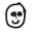

In [12]:
from bwb.distributions import DistributionDraw
from torchvision import disable_beta_transforms_warning
disable_beta_transforms_warning()

import torchvision.transforms.v2 as T


z = noise_sampler(1)
m = G(z)

transform_in = T.Compose([
    T.Lambda(lambda x: x / torch.max(x)),
    T.ToPILImage(),
    T.Resize(32),
    T.ToImage(),
    T.ConvertImageDtype(torch.float32),
    T.Normalize((0.5,), (0.5,)),
])

transform_out_ = T.Compose([
    T.ToDtype(torch.float64),
    T.Lambda(lambda x: x.squeeze()),
    T.Lambda(lambda x: x - torch.min(x)),
    T.Lambda(lambda x: x / torch.sum(x)),
])

transform_out = T.Compose([
    transform_out_,
    T.Lambda(lambda x: DistributionDraw.from_grayscale_weights(x)),
])

out: DistributionDraw = transform_out(m)
print(out.dtype)
out

Definimos la distribución:

In [13]:
from bwb.distributions.distribution_samplers import GeneratorDistribSampler

dist_sampler = GeneratorDistribSampler().fit(generator=G, transform_out=transform_out_, noise_sampler=noise_sampler)
dist_sampler

GeneratorDistribSampler()

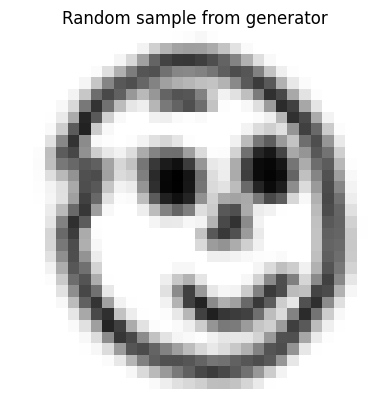

In [14]:
_ = plotters.plot_draw(dist_sampler.draw(), title="Random sample from generator")

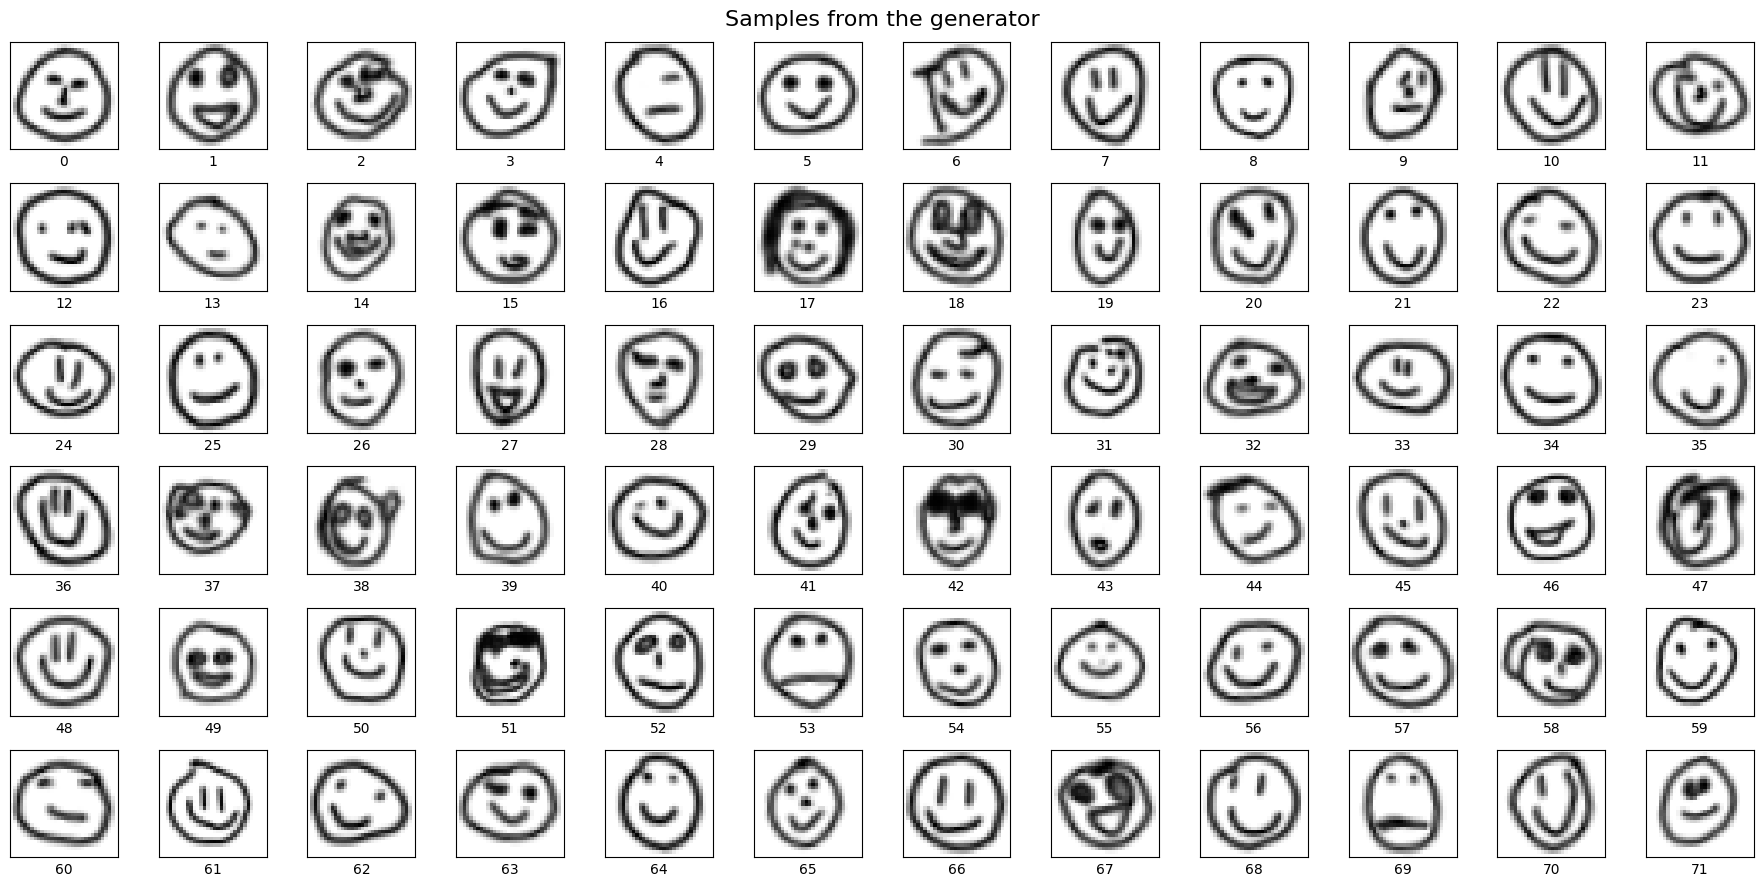

In [15]:
import bwb.plotters as plotters

n_rows, n_cols = 6, 12
max_imgs = n_rows * n_cols
fig, ax = plotters.plot_list_of_draws(
    dist_sampler.rvs(max_imgs), 
    n_rows=n_rows, n_cols=n_cols,
    title=f"Samples from the generator"
)

In [16]:
if SAVE_FIGS:
    PATH_TO_SAVE = IMGS_PATH / f"{dist_sampler.__class__.__name__}-{n_rows}x{n_cols}"
    fig.savefig(PATH_TO_SAVE.with_suffix(".pdf"))
    fig.savefig(PATH_TO_SAVE.with_suffix(".png"))